# Fine tuning BERT for information retrieval using Amazon Sagemaker 

## Clone the git repository to access and run the code

In [ ]:
!git clone https://github.com/aws-samples/amazon-sagemaker-workshop-for-huggingface

## Install and import dependencies

In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-q", "-m", "pip", "install", package])
    
install('sentence_transformers')

import json
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, LoggingHandler, util, models, evaluation, losses, InputExample
import logging
from datetime import datetime
import gzip
import os
import tarfile
from collections import defaultdict
from torch.utils.data import IterableDataset
import tqdm
from torch.utils.data import Dataset
import random
import pickle
import argparse
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

## Setup the Sagemaker session and the role

In [69]:
sess = sagemaker.Session()

role = get_execution_role()
role

output_path = "s3://" + sess.default_bucket() + "/nlp-dualencoder"
#output_path

role

'arn:aws:iam::445083327804:role/rekognition-immersion-day-sagemaker-ExecutionRole-1TWHELAV9NI44'

## Sample Training input instance

## Train the Bi-Encoder

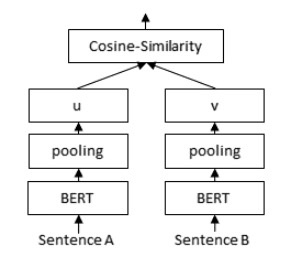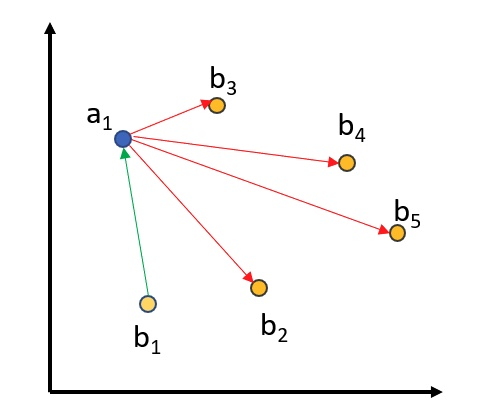

#### References: https://www.sbert.net/examples/training/ms_marco/README.html

In [ ]:
local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.m5.24xlarge"

est = PyTorch(
    entry_point="nlp_loader_test.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="1.5.0",
    py_version="py3",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    #hyperparameters={"batch-size": 128, "epochs": 1, "learning-rate": 1e-3, "log-interval": 100},
)

est.fit()

## Model Inference

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
entry_point = 'inference.py',
    source_dir="code",
   model_data='s3://sagemaker-us-east-1-445083327804/nlp-dualencoder/pytorch-training-2022-09-03-21-01-05-224/output/model.tar.gz',       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17.0",  # transformers version used
   pytorch_version="1.10.2",        # pytorch version used
   py_version='py38',            # python version used
)



## Realtime endpoint for queries

In [ ]:
# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge"
    )
query_vector = predictor.predict({
	'inputs': "The answer to the universe is GOD."
})
query_vector['vectors'][0]

## Copy model extracts to local

In [ ]:
!aws s3 cp s3://sagemaker-us-east-1-445083327804/nlp-dualencoder/pytorch-training-2022-09-03-21-01-05-224/output/model.tar.gz ./
!tar -xvzf model.tar.gz -C ./trained_bert_model_extract

## Batch Transform the docs to vectors

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel
import torch
import torch.nn.functional as F
import os

from itertools import islice
import math
import pandas as pd
from numpy.random import randint


def take_(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))


model_data='./trained_bert_model_extract'

dataframe_list=[]
cols = ['docs','bert_encoded_doc_vectors']

tokenizer = AutoTokenizer.from_pretrained(model_data)
model = BertModel.from_pretrained(model_data)

### Now we read the MS Marco dataset
data_folder = 'msmarco-data'

#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}         #dict in the format: passage_id -> passage. Stores all existent passages
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    tar_filepath = os.path.join(data_folder, 'collection.tar.gz')
    if not os.path.exists(tar_filepath):
        logging.info("Download collection.tar.gz")
        util.http_get('https://msmarco.blob.core.windows.net/msmarcoranking/collection.tar.gz', tar_filepath)

    with tarfile.open(tar_filepath, "r:gz") as tar:
        tar.extractall(path=data_folder)

logging.info("Read corpus: collection.tsv")
with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        pid = int(pid)
        corpus[pid] = passage

n_items = take_(2, corpus.items())

print(n_items)

for key in n_items.items():

    tmp_list=[]
    encoded_input = tokenizer(n_items[key[0]], padding=True, truncation=True, return_tensors='pt')["input_ids"]
    bert_encoded = model(encoded_input)["pooler_output"].tolist()
    tmp_list.append(n_items[key[0]])
    tmp_list.append(bert_encoded[0])
    print(tmp_list)
    dataframe_list.append(tmp_list)
transformed_dataframe = pd.DataFrame(dataframe_list, columns=cols)

transformed_dataframe.to_csv('./transfromed_vectors.csv',index=False)
!aws s3 cp ./transfromed_vectors.csv s3://sagemaker-us-east-1-445083327804/nlp-dualencoder/batch_output/

## OpenSearch domain

In [75]:
import sagemaker
import boto3




sts_client = boto3.client('sts')

# Call the assume_role method of the STSConnection object and pass the role
# ARN and a role session name.

assumed_role_object=sts_client.assume_role(
    RoleArn="arn:aws:iam::445083327804:role/cfn-test-final-ExecutionRole-2ZY39TBJ6ED6",
    RoleSessionName="AssumeRoleSession1"
)

# From the response that contains the assumed role, get the temporary 
# credentials that can be used to make subsequent API calls

credentials=assumed_role_object['Credentials']


session = boto3.Session(
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

credentials = session.get_credentials()
#credentials = boto3.Session().get_credentials()


# print(f"sagemaker bucket: {sess.default_bucket()}")
# print(f"sagemaker session region: {sess.boto_region_name}")
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import boto3

#https://vpc-opensearch-test-detvd5qf5kikn3o2tqy4owcd4a.us-east-1.es.amazonaws.com

host = 'vpc-search-bert-test5-tip3ulnz6lihzp37yymtpcjiqy.us-east-1.es.amazonaws.com'
port = 443

s3 = boto3.client('s3')
import re
import requests
import json

from requests_aws4auth import AWS4Auth
endpoint = 'https://vpc-search-bert-test5-tip3ulnz6lihzp37yymtpcjiqy.us-east-1.es.amazonaws.com' # the proxy endpoint, including https://
region = 'us-east-1' # e.g. us-west-1
index = 'movies' # index name
service = 'execute-api'
#credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region)
url = endpoint + '/' + index + '/_doc'
headers = { "Content-Type": "application/json"
}



client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    #verify_certs = True,
    connection_class = RequestsHttpConnection
)

client



<OpenSearch([{'host': 'vpc-opensearch-test-detvd5qf5kikn3o2tqy4owcd4a.us-east-1.es.amazonaws.com', 'port': 443}])>

## create index and mapping

In [72]:
index_name = 'nlpindex_search_bert_19sep'
index_body = {
  'settings': {
    'index': {
      'number_of_shards': 4,
        'knn': True
    }
  },

    'mappings': {
       
            'properties': {
                'passage': {'type': 'text'},
                
               "bert_vector": {
        "type": "knn_vector",
        "dimension": 768
      },
            }}
}


response = client.indices.create(index_name, body=index_body)
print('\nCreating index:')
print(response)




Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'nlpindex_search_bert_19sep'}


## Index the document and vectors (Batch Transform)

In [ ]:
import pandas as pd
import s3fs
from ast import literal_eval

df = pd.read_csv('s3://sagemaker-us-east-1-445083327804/nlp-dualencoder/batch_output/transfromed_vectors.csv')
df

df = df.reset_index()  # make sure indexes pair with number of rows

for index, row in df.iterrows():
    line={}
    line['passage']=row['docs']
    line['bert_vector']=literal_eval(row['bert_encoded_doc_vectors'])

    response = client.index(
    index = index_name,
    body = line)
    print(response)

## Search the domain in realtime using sagemaker endpoint and lambda

In [ ]:
query_vector = predictor.predict({
	'inputs': "The answer to the universe is GOD."
})

q = 'miller'
query = {"query":{
  "knn": {
      "bert_vector": {
        "vector": query_vector['vectors'][0],
        "k": 1
      }
    }
}}


response = client.search(
    body = query,
    index = index_name
)
print('\nSearch results:')
print(response)

## Mini Search Engine

In [64]:
from ipywidgets import interact, widgets
from IPython.display import display
import boto3
import json
from ast import literal_eval
lambda_client = boto3.client('lambda')

text = widgets.Text(
    value='Search here!',
    placeholder='Search here!',
    description='Search:',
    disabled=False
)

text.style._view_name = '100px'

display(text)

def callback(wdgt):
    lambda_payload_ = json.dumps({"inputs": wdgt.value})

    res = lambda_client.invoke(FunctionName='sagemaker-access-endpoints', 
                     InvocationType='RequestResponse',
                     Payload=lambda_payload_)
    res=literal_eval(res['Payload'].read().decode())
    
    

    q = 'miller'
    query = {"query":{
    "knn": {
      "bert_vector": {
        "vector": res,
        "k": 1
      }
        }
    }}


    response = client.search(
    body = query,
    index = 'nlpindex_search_bert_14sep'
    )
    result = {}
    result['doc']=response['hits']['hits'][0]['_source']['passage']
    result['score']=response['hits']['hits'][0]['_score']
    display(result)

text.on_submit(callback)

Text(value='Search here!', description='Search:', placeholder='Search here!')

In [79]:
!zip -r temp.zip ./

  adding: lost+found/ (stored 0%)
  adding: code/ (stored 0%)
  adding: code/inference.py (deflated 53%)
  adding: code/nlp_loader_test.py (deflated 66%)
  adding: code/nlp-dualEncoder.py (deflated 69%)
  adding: transfromed_vectors.csv (deflated 53%)
  adding: Untitled.ipynb (deflated 70%)
  adding: model.tar.gz (deflated 0%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/Untitled-checkpoint.ipynb (deflated 74%)
  adding: .ipynb_checkpoints/sagemaker-dualencoder-training-msmarco-checkpoint.ipynb (deflated 46%)
  adding: .sparkmagic/ (stored 0%)
  adding: amazon-sagemaker-workshop-for-huggingface/ (stored 0%)
  adding: amazon-sagemaker-workshop-for-huggingface/inference/ (stored 0%)
  adding: amazon-sagemaker-workshop-for-huggingface/inference/lab2_deploy_transformer_batch_from_s3/ (stored 0%)
  adding: amazon-sagemaker-workshop-for-huggingface/inference/lab2_deploy_transformer_batch_from_s3/deploy_transformer_batch_from_s3.ipynb (deflated 71%)
  adding: amazon-

In [80]:
!rm -r ./amazon-sagemaker-workshop-for-huggingface

rm: remove write-protected regular file ‘./amazon-sagemaker-workshop-for-huggingface/.git/objects/pack/pack-505627e9472d579496529894b29eb3686d5cda15.idx’? ^C
